In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!cp /content/drive/'My Drive'/kaggle.json .
!cp /content/drive/'My Drive'/tweeter/utils_for_ml.py .

In [0]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle

In [6]:
!kaggle competitions download -c nlp-getting-started

  0% 0.00/965k [00:00<?, ?B/s]
100% 965k/965k [00:00<00:00, 63.9MB/s]
  0% 0.00/411k [00:00<?, ?B/s]
100% 411k/411k [00:00<00:00, 127MB/s]
  0% 0.00/22.2k [00:00<?, ?B/s]
100% 22.2k/22.2k [00:00<00:00, 22.9MB/s]


In [0]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from scipy import spatial

import csv
import re

from utils_for_ml import *

In [0]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

##Feature engineering:

Extracting tags:

In [0]:
train['tags'] = train['text'].str.findall(r'#.*?(?=\s|$)')
test['tags'] = test['text'].str.findall(r'#.*?(?=\s|$)')

In [10]:
train.head(10)

,id,keyword,location,text,target,tags
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,[#earthquake]
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,[]
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,[]
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,[#wildfires]
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[#Alaska, #wildfires]"
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1,"[#RockyFire, #CAfire, #wildfires]"
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1,"[#flood, #disaster]"
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1,[]
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1,[]
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1,[]


Let's add some extra columns that will show rows with an empty list, I think that it can be a good feature for future model:

In [0]:
train['no_tags'] = train['tags'].apply(lambda tags: True if len(tags)==0 else False)
test['no_tags'] = test['tags'].apply(lambda tags: True if len(tags)==0 else False)

And let's make the same extra feature for 'location' column:

In [0]:
train['no_location'] = train['location'].isna()
test['no_location'] = test['location'].isna()

Let's have a look at our changes:

In [13]:
train.head()

,id,keyword,location,text,target,tags,no_tags,no_location
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,[#earthquake],False,True
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,[],True,True
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,[],True,True
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,[#wildfires],False,True
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[#Alaska, #wildfires]",False,True


As I didn't get good results using tags as features, even trying to apply lemmatization or stemming I will try to use pre-trained GloVe vectors for each tag. I hope that tags that are semantical similar will be close in space of GloVe vectors.

In [0]:
words = pd.read_table('/content/drive/My Drive/GloVe/glove.twitter.27B.200d.txt',
                      sep=" ",
                      index_col=0,
                      header=None,
                      quoting=csv.QUOTE_NONE)

In [0]:
def vec(word):
  try:
    return words.loc[word].values
  except:
    return np.zeros((200,))

Replacing '#' and lowercasing to get vectors:

In [0]:
train['tags'] = train['tags'].apply(lambda tags: [tag.lower().replace('#', '') for tag in tags])
test['tags'] = test['tags'].apply(lambda tags: [tag.lower().replace('#', '') for tag in tags])

Adding new columns of vectors:

In [0]:
train['tags_vectors'] = train['tags'].apply(lambda tags: [vec(tag) for tag in tags])
test['tags_vectors'] = test['tags'].apply(lambda tags: [vec(tag) for tag in tags])

In [18]:
train.head()

,id,keyword,location,text,target,tags,no_tags,no_location,tags_vectors
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,[earthquake],False,True,"[[-0.32275, 0.14165, 0.053551, -0.53203, -0.14..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,[],True,True,[]
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,[],True,True,[]
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,[wildfires],False,True,"[[0.27762, 0.31333, -0.89246, -0.050292, -0.59..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[alaska, wildfires]",False,True,"[[-0.27928000000000003, -0.067628, -0.50753, -..."


In [0]:
def empty_list(tags):
  if len(tags) == 0:
    tags.append(np.zeros((200,)))
    return tags
  else:
    return tags

As some of lists are empty we need to represent them as vectors too. I will use zeros for them:

In [0]:
train['tags_vectors'] = train['tags_vectors'].apply(lambda tags: empty_list(tags))
test['tags_vectors'] = test['tags_vectors'].apply(lambda tags: empty_list(tags))

In [21]:
train.head()

,id,keyword,location,text,target,tags,no_tags,no_location,tags_vectors
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,[earthquake],False,True,"[[-0.32275, 0.14165, 0.053551, -0.53203, -0.14..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,[],True,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,[],True,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,[wildfires],False,True,"[[0.27762, 0.31333, -0.89246, -0.050292, -0.59..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[alaska, wildfires]",False,True,"[[-0.27928000000000003, -0.067628, -0.50753, -..."


###Math with Words

As some of the tweets have several tags, I decided to use 'Math with Words' and just sum them:

In [0]:
words_matrix = words.values

def find_closest_word(vector):
  diff = words_matrix - vector
  delta = np.sum(diff * diff, axis=1)
  i = np.argmin(delta)
  return words.iloc[i].name

For example:

In [23]:
find_closest_word(vec('mobile')-vec('phone'))

'flasharabia'

Emm, Arabic, can be...

But in our case:

In [24]:
sorted(train['tags'].values, reverse=True)[3]

['zionist', 'terrorist', 'palestinians']

In [25]:
find_closest_word(vec('zionist') + vec('terrorist') + vec('palestinians'))

'terrorist'

Quite logical, so I will save the result in another column, and then will calculate the average of vectors to compare:

In [0]:
train['sum_tags_vectors'] = train['tags_vectors'].apply(lambda tags: np.sum(np.array(tags), axis=0))
test['sum_tags_vectors'] = test['tags_vectors'].apply(lambda tags: np.sum(np.array(tags), axis=0))

In [27]:
train.head()

,id,keyword,location,text,target,tags,no_tags,no_location,tags_vectors,sum_tags_vectors
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,[earthquake],False,True,"[[-0.32275, 0.14165, 0.053551, -0.53203, -0.14...","[-0.32275, 0.14165, 0.053551, -0.53203, -0.141..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,[],True,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,[],True,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,[wildfires],False,True,"[[0.27762, 0.31333, -0.89246, -0.050292, -0.59...","[0.27762, 0.31333, -0.89246, -0.050292, -0.590..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[alaska, wildfires]",False,True,"[[-0.27928000000000003, -0.067628, -0.50753, -...","[-0.0016600000000000503, 0.245702, -1.39999, -..."


##Model:

In [0]:
labels = train['target']

features = np.array(train.sum_tags_vectors.values.tolist())
test_features = np.array(test.sum_tags_vectors.values.tolist())

In [34]:
train_prediction = cross_val(features,
                             labels, 
                             model_type = 'knn', 
                             k_neighbors = 9,
                             n_folds = 5)

Training Data Shape:  (7613, 200)

F1 Score: 0.5195989061075662


In [0]:
prediction = train.copy()

prediction['glove_tags_pred'] = train_prediction
prediction = prediction.drop(columns = ['keyword', 'location', 'text', 'tags', 'target', 'tags_vectors', 'sum_tags_vectors'])

In [36]:
prediction.head()

,id,no_tags,no_location,glove_tags_pred
0,1,False,True,1.000000
1,4,True,True,0.666667
2,5,True,True,0.666667
3,6,False,True,1.000000
4,7,False,True,0.888889


I think that it was a good idea to add 'no_tags' column. As we can see, rows, where tweets don't have any tag, got probability closer to 0.5

In [0]:
model = KNeighborsClassifier(n_neighbors=9)

model.fit(features, labels)

test_prediction = model.predict_proba(test_features)

In [0]:
test_predictions = test.copy()

test_predictions['glove_tags_pred'] = test_prediction[:, 1]

test_predictions = test_predictions.drop(columns = ['keyword', 'location', 'text', 'tags', 'tags_vectors', 'sum_tags_vectors'])

In [39]:
test_predictions.head()

,id,no_tags,no_location,glove_tags_pred
0,0,True,True,0.777778
1,2,False,True,1.000000
2,3,True,True,0.777778
3,9,False,True,1.000000
4,11,True,True,0.777778


##Location column analysis:

Let's explore 'location' column:

In [40]:
train.location.describe()

count     5080
unique    3341
top        USA
freq       104
Name: location, dtype: object

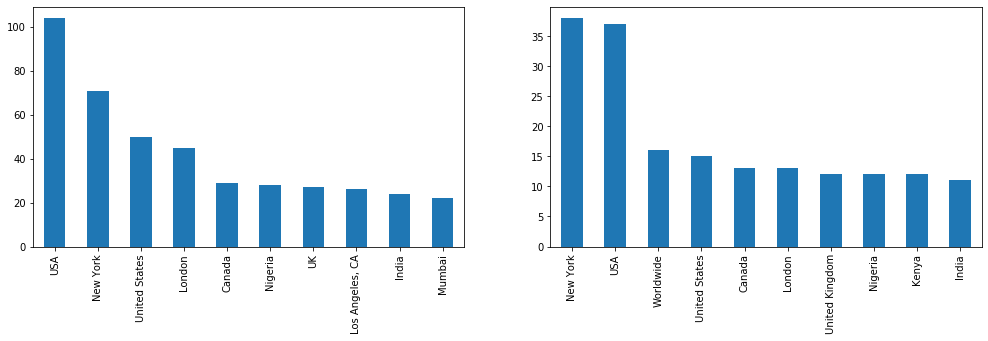

In [41]:
plt.figure(figsize=(17,15))

plt.subplot(321)
train['location'].value_counts()[:10].plot(kind='bar')

plt.subplot(322)
test['location'].value_counts()[:10].plot(kind='bar')
plt.show()

In [42]:
train['location'].unique()[:20]

array([nan, 'Birmingham', 'Est. September 2012 - Bristol', 'AFRICA',
       'Philadelphia, PA', 'London, UK', 'Pretoria', 'World Wide!!',
       'Paranaque City', 'Live On Webcam', 'milky way',
       'GREENSBORO,NORTH CAROLINA', 'England.',
       'Sheffield Township, Ohio', 'India', 'Barbados', 'Anaheim',
       'Abuja', 'USA', 'South Africa'], dtype=object)

As we can see, some of the locations have something like region or country after coma, we need to remove it, as there is no vector corresponding "Los Angeles, CA", but there is the vector for "losandeles".

In [0]:
def remove_region(location):
    try:
        html=re.compile(r',.*')
        return html.sub(r'',location)
    except:
        return None

In [0]:
train['location'] = train['location'].apply(lambda location: remove_region(location))
test['location'] = test['location'].apply(lambda location: remove_region(location))

Dropping punctuation and spaces:

In [0]:
def just_letters(location):
    try:
        html=re.compile(r'[^\w]')
        return html.sub(r'',location)
    except:
        return ''

In [0]:
train['location'] = train['location'].apply(lambda location: just_letters(location).lower())
test['location'] = test['location'].apply(lambda location: just_letters(location).lower())

Getting vectors:

In [0]:
train['locations_vector'] = train['location'].apply(lambda location: vec(location))
test['locations_vector'] = test['location'].apply(lambda location: vec(location))

In [0]:
features = np.array(train.locations_vector.values.tolist())
test_features = np.array(test.locations_vector.values.tolist())

In [58]:
train_prediction = cross_val(features, 
                             labels, 
                             model_type = 'knn',
                             k_neighbors = 27,
                             n_folds = 5)

Training Data Shape:  (7613, 200)

F1 Score: 0.47096492504730025


In [0]:
prediction['glove_loc_pred'] = train_prediction

In [60]:
prediction.head()

,id,no_tags,no_location,glove_tags_pred,glove_loc_pred
0,1,False,True,1.000000,0.481481
1,4,True,True,0.666667,0.518519
2,5,True,True,0.666667,0.407407
3,6,False,True,1.000000,0.555556
4,7,False,True,0.888889,0.592593


In [0]:
model = KNeighborsClassifier(n_neighbors=27)

model.fit(features, labels)

test_prediction = model.predict_proba(test_features)

In [0]:
test_predictions['loc_pred'] = test_prediction[:, 1]

In [63]:
test_predictions.head()

,id,no_tags,no_location,glove_tags_pred,loc_pred
0,0,True,True,0.777778,0.407407
1,2,False,True,1.000000,0.407407
2,3,True,True,0.777778,0.407407
3,9,False,True,1.000000,0.407407
4,11,True,True,0.777778,0.407407


In [0]:
prediction.to_csv('/content/drive/My Drive/tweeter/train_predictions_glove.csv', index_label='idx')
test_predictions.to_csv('/content/drive/My Drive/tweeter/test_predictions_glove.csv', index_label='idx')